# Sieć Kohonena
## LAB2
## Piotr Fic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Implementacja

In [2]:
class KohonenNet:
    
    def __init__(self, N, M, n, weights="hexagon"):
        self.M = M
        self.N = N
        self.n = n
        if weights=="hexagon":
            self.weights = self.hexagon_weights(self.N, self.M, self.n)
        else:
            self.weights = np.random.uniform(0, 1, size = (self.M, self.N, self.n))
                
    def fit(self, X, n_iter, neig_fun, neig_param, etha):
        if neig_fun=="gauss":
            n_f = self.gauss
        elif neig_fun=="mexico":
            n_f = self.mexico
        else:
            assert("Neighbourhood fun: gauss or mexico")
                
        for i in range(1, n_iter+1):
            rows = np.random.permutation(len(X))
            for x in X[rows]:
                #searching for min distance with x
                min_dist = np.inf
                min_id = -1
                for r in range(self.N):
                    for c in range(self.M):
                        w = self.weights[r][c]
                        if w is not None:
                            dist = np.linalg.norm(x-w)
                            if dist<min_dist:
                                min_dist = dist
                                min_id = np.array([r, c])
                #updatng neighbourhood
                for r in range(self.N):
                    for c in range(self.M):
                        w = self.weights[r][c]
                        if w is not None:
                            dist = np.linalg.norm(min_id-np.array([r, c]))
                            update = n_f(neig_param*dist, i)*etha*np.exp(-i)*(x-w)
                            self.weights[r][c] = w + update
                
    #neighbourhood functions
    def gauss(self, d, i):
        return np.exp(-1*(d)**2)
    
    def mexico(self, d, t):
        return (2-4*d**2)*np.exp(-d**2)
    
    def find_classes(self, X, X_classes):
        k = max(X_classes)+1
        self.classes = np.full(shape=(self.N, self.M, k), fill_value=0)
        for x, x_c in zip(X, X_classes):
            #searching for min distance with x
            min_dist = np.Inf
            min_r = None
            min_c = None
            for i in range(self.N):
                for j in range(self.M):
                    w = self.weights[i][j]
                    if w is not None:
                        dist = np.linalg.norm(x-w)
                        if dist<min_dist:
                            min_dist = dist
                            min_r = i
                            min_c = j

            #adding class count for closest neuron
            self.classes[min_r][min_c][x_c] += 1
                        
        out = [[None]*self.M for i in range(self.N)]
        for i in range(self.N):
            for j in range(self.M):
                if sum(self.classes[i][j])>0:
                    out[i][j] = np.argmax(self.classes[i][j])
        return out
    
    def hexagon_weights(self, N, M, dim):
        weights = [[None]*M for i in range(N)]
        r_flag = 1
        c_flag = 1
        for r in range(N):
            for c in range(M):
                if r_flag==1:
                    if c_flag==2 or c_flag==3:
                        weights[r][c] = np.random.uniform(0, 1, size=dim)
                else:
                    if c_flag==1 or c_flag==4:
                        weights[r][c] = np.random.uniform(0, 1, size=dim)
                if c_flag<4:
                    c_flag += 1
                else:
                    c_flag = 1
            if r_flag<2:
                r_flag += 1
            else:
                r_flag = 1
            c_flag = 1
        return weights
    
    def find_points(self):
        points = []
        for r in range(self.N):
            for c in range(self.M):
                if self.weights[r][c] is not None:
                    points.append(self.weights[r][c])
        return np.array(points)
    
    def predict(self, x):
        if self.classes is None:
            assert("Find neurons class labels with find_classes!")
        res = None
        min_dist = np.inf
        for r in range(self.N):
            for c in range(self.M):
                w = self.weights[r][c]
                if w is not None:
                    dist = np.linalg.norm(x-w)
                    if dist<min_dist:
                        min_dist = dist
                        res = np.argmax(self.classes[r][c])
        return res

In [3]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

## Testy działania
### Metodologia
 - podział zbioru na część treningową i testową
 - nauczenie sieci na części treningowej (do doboru parametrów próbka danych)
 - nadanie neuronom klas według etykiet z części treningowej
 - zmierzenie ACC na części treningowej (dobór hiperparametrów)
 - klasyfikacja obserwacji ze zbioru testowego najlepszym modelem

### df: "MNIST"

In [27]:
# Loading MNIST dataset
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X, test_X = train_X.reshape(-1, 784), test_X.reshape(-1, 784)
# Scaling data to [0, 1]
train_X, test_X = normalize(train_X), normalize(test_X) 

In [10]:
# Params grid with sklearn for convinence
from sklearn.model_selection import ParameterGrid
param_grid = {
    'top': ["hexagon", "rectangle"], 
    'neig_fun': ["gauss", "mexico"],
    'neig_param': [0.1, 0.8, 0.9],
    'n_iter': [10, 15, 20],
    'etha': [0.01, 0.1, 1],   
}
grid = ParameterGrid(param_grid)

In [10]:
# Subsample id (10%)
ids = random.sample(range(len(train_y)), 6000)

In [16]:
def pred_score(test_X, test_y, kn):
    pred = []
    for x in test_X:
        pred.append(kn.predict(x))
    return (pred==test_y).mean()

In [ ]:
# Fitting best hyperparameters on training set
scores = []
i = 0
for p in grid:
    i += 1
    print("Next params no: " + str(i))
    kn = KohonenNet(5, 5, 784, weights=p['top'])
    kn.fit(train_X[ids], n_iter=p['n_iter'], neig_fun=p['neig_fun'], neig_param=p['neig_param'], etha=p['etha'])
    klasy = kn.find_classes(train_X[ids], train_y[ids])
    scr = pred_score(train_X[ids], train_y[ids], kn)
    scores.append([p, scr])
    print("Achieved score: " + str(scr))

In [25]:
# cv results to data frame
scores = np.load("./cv_mnist.npy", allow_pickle=True)
cv_mnist = []
for r in scores:
    cv_mnist.append(np.append(r[1], list(r[0].values())))
df_mnist = pd.DataFrame(cv_mnist, columns=["acc", "etha", "n_iter", "neig_fun", "neig_param", "top"])

### Najlepsze parametry
#### Topologia: hexagon

In [32]:
df_mnist[df_mnist.top == "hexagon"].sort_values("acc", ascending=False)[0:5]

,acc,etha,n_iter,neig_fun,neig_param,top
76,0.5918333333333333,1,10,gauss,0.9,hexagon
40,0.59,0.1,10,gauss,0.9,hexagon
88,0.5846666666666667,1,15,gauss,0.9,hexagon
100,0.5763333333333334,1,20,gauss,0.9,hexagon
52,0.5746666666666667,0.1,15,gauss,0.9,hexagon


#### Topologia: rectangle

In [33]:
df_mnist[df_mnist.top == "rectangle"].sort_values("acc", ascending=False)[0:5]

,acc,etha,n_iter,neig_fun,neig_param,top
65,0.6333333333333333,0.1,20,gauss,0.9,rectangle
51,0.6305,0.1,15,gauss,0.8,rectangle
41,0.6226666666666667,0.1,10,gauss,0.9,rectangle
101,0.6218333333333333,1,20,gauss,0.9,rectangle
89,0.6121666666666666,1,15,gauss,0.9,rectangle


### Ewaluacja na pełnym zbiorze

In [34]:
# training on full train set, and scoring on test 5-times
acc = []
for i in range(5):
    kn_hex = KohonenNet(5, 5, 784, weights="hexagon")
    kn_hex.fit(train_X, n_iter=10, neig_fun="gauss", neig_param=0.9, etha=1)
    kn_rec = KohonenNet(5, 5, 784, weights="rectangle")
    kn_rec.fit(train_X, n_iter=20, neig_fun="gauss", neig_param=0.9, etha=0.1)
    kn_hex.find_classes(train_X, train_y)
    kn_rec.find_classes(train_X, train_y)
    scr_hex = pred_score(test_X, test_y, kn_hex)
    scr_rec = pred_score(test_X, test_y, kn_rec)
    acc.append([scr_hex, scr_rec])
mnist_test_acc = pd.DataFrame(acc, columns=["acc_hex", "acc_rec"])

#### MNIST: wyniki zbiór testowy

In [2]:
#mnist_test_acc.to_csv("mnist_test_acc.csv")
mnist_test_acc = pd.read_csv("mnist_test_acc.csv", index_col=0)
mnist_test_acc.describe()

,acc_hex,acc_rec
count,5.000000,5.000000
mean,0.583560,0.625420
std,0.021584,0.016192
min,0.547500,0.609000
25%,0.581700,0.609100
50%,0.588900,0.626700
75%,0.599400,0.638300
max,0.600300,0.644000


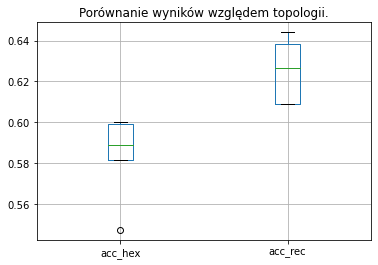

In [4]:
mnist_test_acc.boxplot()
plt.title("Porównanie wyników względem topologii.")
plt.show()

### Ocena
- dla obu topologii lepszą funkcją sąsiedztwa była funkcja gaussowska
- sieć osiągnęła lepsze wyniki w topologii prostokątnej
- wyniki dla obu wersji były stabilne

### df: "Human Activity"

In [34]:
# Loading data
train_X = pd.read_csv("./UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
train_y = pd.read_csv("./UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
test_X = pd.read_csv("./UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
test_y = pd.read_csv("./UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", sep="\s+", header=None)
# Scaling data to [0, 1]
train_X, test_X = normalize(train_X), normalize(test_X)
train_X, test_X = np.array(train_X), np.array(test_X)
train_y, test_y = np.array(train_y)[0], np.array(test_y)[0]

In [ ]:
# Fitting best hyperparameters on training set
scores = []
i = 0
for p in grid:
    i += 1
    print("Next params no: " + str(i))
    kn = KohonenNet(5, 5, 561, weights=p['top'])
    kn.fit(train_X, n_iter=p['n_iter'], neig_fun=p['neig_fun'], neig_param=p['neig_param'], etha=p['etha'])
    klasy = kn.find_classes(train_X, train_y)
    scr = pred_score(train_X, train_y, kn)
    scores.append([p, scr])
    print("Achieved score: " + str(scr))

In [37]:
#np.save("cv_uci", scores)
# cv results to data frame
scores = np.load("./cv_uci.npy", allow_pickle=True)
cv_uci = []
for r in scores:
    cv_uci.append(np.append(r[1], list(r[0].values())))
df_uci = pd.DataFrame(cv_uci, columns=["acc", "etha", "n_iter", "neig_fun", "neig_param", "top"])

### Najlepsze parametry
#### Topologia: hexagon

In [38]:
df_uci[df_uci.top == "hexagon"].sort_values("acc", ascending=False)[0:5]

,acc,etha,n_iter,neig_fun,neig_param,top
68,1.0,0.1,20,mexico,0.8,hexagon
22,1.0,0.01,15,mexico,0.9,hexagon
32,0.999727965179543,0.01,20,mexico,0.8,hexagon
8,0.9980957562568009,0.01,10,mexico,0.8,hexagon
20,0.9960554951033732,0.01,15,mexico,0.8,hexagon


#### Topologia: rectangle

In [39]:
df_uci[df_uci.top == "rectangle"].sort_values("acc", ascending=False)[0:5]

,acc,etha,n_iter,neig_fun,neig_param,top
81,1.0,1,10,mexico,0.8,rectangle
93,1.0,1,15,mexico,0.8,rectangle
21,0.999727965179543,0.01,15,mexico,0.8,rectangle
33,0.9949673558215452,0.01,20,mexico,0.8,rectangle
23,0.9948313384113167,0.01,15,mexico,0.9,rectangle


### Ewaluacja na zbiorze testowym

In [ ]:
# training on full train set, and scoring on test 5-times
acc = []
for i in range(5):
    print("Iter: " + str(i))
    kn_hex = KohonenNet(5, 5, 561, weights="hexagon")
    kn_hex.fit(train_X, n_iter=20, neig_fun="mexico", neig_param=0.8, etha=0.1)
    kn_rec = KohonenNet(5, 5, 561, weights="rectangle")
    kn_rec.fit(train_X, n_iter=10, neig_fun="mexico", neig_param=0.8, etha=1)
    kn_hex.find_classes(train_X, train_y)
    kn_rec.find_classes(train_X, train_y)
    scr_hex = pred_score(test_X, test_y, kn_hex)
    scr_rec = pred_score(test_X, test_y, kn_rec)
    acc.append([scr_hex, scr_rec])
uci_test_acc = pd.DataFrame(acc, columns=["acc_hex", "acc_rec"])
uci_test_acc.to_csv("uci_test_acc.csv")

In [5]:
uci_test_acc = pd.read_csv("uci_test_acc.csv", index_col=0)
uci_test_acc.describe()

,acc_hex,acc_rec
count,5.000000,5.000000
mean,0.714354,0.619138
std,0.260758,0.212908
min,0.523923,0.523923
25%,0.523923,0.523923
50%,0.523923,0.523923
75%,1.000000,0.523923
max,1.000000,1.000000


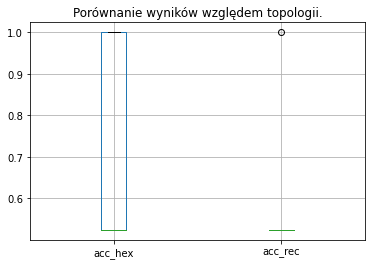

In [6]:
uci_test_acc.boxplot()
plt.title("Porównanie wyników względem topologii.")
plt.show()

### Ocena
- w przypadku tego zbioru skuteczniejsza okazała się funkcja "meksykańskiego kapelusza"
- również w przeciwieństwie do MNIST wyższy średni wynik osiągała sieć w topologii sześciokątnej
- w przypadku tego zbioru wahania rezultatów były większe
- poprawę wyników przyniosłoby z pewnością zwiększenie liczby neuronów w sieciach, lecz ze względów czasochłonności obliczeń uznaję te wyniki za reprezentatywne do analizy wyników sieci i wpływu doboru parametrów